# Explore International Football Match data

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

First, let's load the rankings and results and find some interesting insights from the data.

In [3]:
#folder = '/l/kaggle/int-football/'
folder = '/Users/kurkil1/data/football/'
rankings = pd.read_csv(os.path.join(folder, 'fifa_ranking-2024-06-20.csv'))

# Load former names
former_names = pd.read_csv(os.path.join(folder, 'former_names.csv'))

# Replace former names with current names in the rankings
rankings = rankings.merge(former_names, how='left', left_on='country_full', right_on='former')
rankings['country_full'] = rankings['country_full'].fillna(rankings['country_full'])
rankings = rankings.drop(columns=['former'])

rankings = rankings.replace({"IR Iran": "Iran"})
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

In [43]:
matches = pd.read_csv(os.path.join(folder, 'results.csv'))
# From results, drop all mathces before 1993 because we don't have rankings for them
matches['date'] = pd.to_datetime(matches['date'])

For an initial data exploration, let's check:
- what team has won the most matches? total/per match
- which match has had the biggest total goals / largest victory?

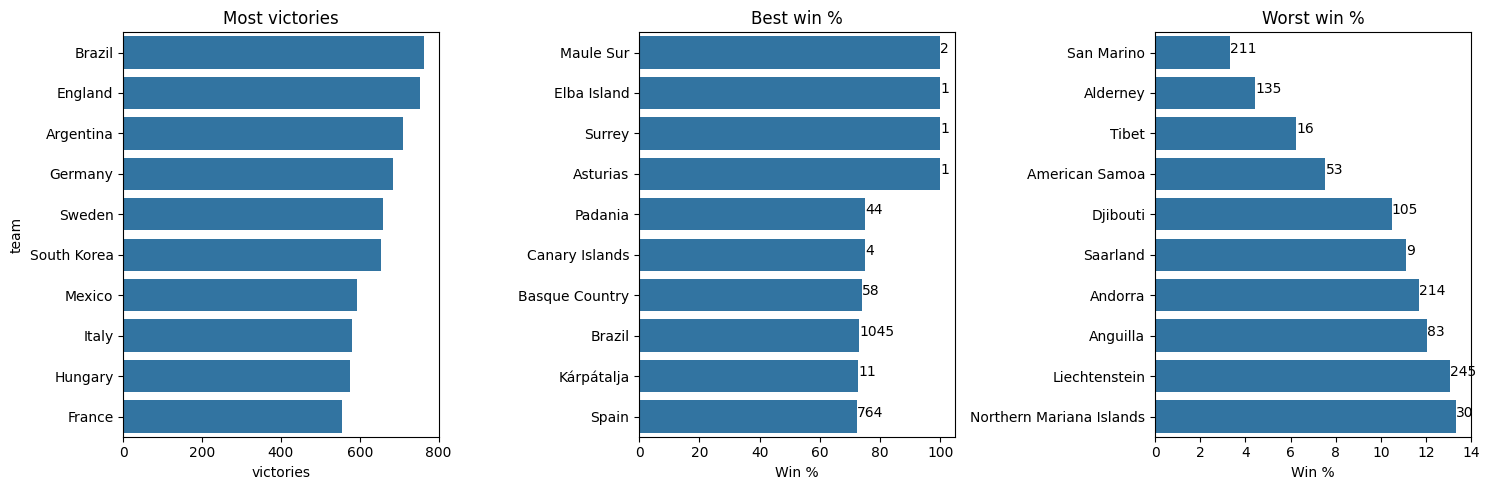

In [44]:
# Get teams with most victories
# Each match has the columns 'home_team' and 'away_team', and 'home_score' and 'away_score'
# We want to count the number of victories for each team

# First, we need to know which team won the match
matches['winner'] = np.where(matches['home_score'] > matches['away_score'], matches['home_team'], matches['away_team'])

# Then, we can count the number of victories for each team
total_wins = matches['winner'].value_counts().reset_index()

# Rename the columns
total_wins.columns = ['team', 'victories']

# Get the number of matches played by each team
ave_wins = pd.concat([matches['home_team'], matches['away_team']]).value_counts().reset_index()
ave_wins.columns = ['team', 'matches_played']

# Merge the two dataframes
wins = total_wins.merge(ave_wins, left_on='team', right_on='team')

# Calculate the ratio of victories
wins['ratio'] = wins['victories'] / wins['matches_played'] * 100

# Plot the 10 teams with most wins and the 10 teams with the best ratio of wins
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x='victories', y='team', data=wins.nlargest(10, 'victories'), ax=ax[0])

sns.barplot(x='ratio', y='team', data=wins.nlargest(10, 'ratio'), ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("Win %")
# Set bar label to the number of matches played
for i in range(10):
    ax[1].text(wins.nlargest(10, 'ratio').iloc[i]['ratio'] + 0.01, i, wins.nlargest(10, 'ratio').iloc[i]['matches_played'])

sns.barplot(x='ratio', y='team', data=wins.nsmallest(10, 'ratio'), ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_xlabel("Win %")
# Set bar label to the number of matches played
for i in range(10):
    ax[2].text(wins.nsmallest(10, 'ratio').iloc[i]['ratio'] + 0.01, i, wins.nsmallest(10, 'ratio').iloc[i]['matches_played'])

ax[0].set_title("Most victories")
ax[1].set_title("Best win %")
ax[2].set_title("Worst win %")

plt.tight_layout()

- The most victories are unsurprisingly Brazil, England and Argentina. Sweden and South Korea also make a suprise appearance in the top 10.
- Funnily enough, Maule Sur, Elba Island, Surrey and Asturias have won every match they have ever played (Padania comes first for teams with more than a few matches).
- San Marino has won only 4 % of their matches

In [49]:
# Find matches with highest total score
matches['total_score'] = matches['home_score'] + matches['away_score']
matches.nlargest(10, 'total_score')[['date', 'home_team', 'away_team', 'home_score', 'away_score']]

# Print the table of the 10 matches with the highest total score in a markdown format
print(matches.nlargest(10, 'total_score')[['date', 'home_team', 'away_team', 'home_score', 'away_score']].to_markdown(index=False))


| date                | home_team      | away_team        |   home_score |   away_score |
|:--------------------|:---------------|:-----------------|-------------:|-------------:|
| 2001-04-11 00:00:00 | Australia      | American Samoa   |           31 |            0 |
| 1971-09-13 00:00:00 | Tahiti         | Cook Islands     |           30 |            0 |
| 1979-08-30 00:00:00 | Fiji           | Kiribati         |           24 |            0 |
| 2001-04-09 00:00:00 | Australia      | Tonga            |           22 |            0 |
| 2006-11-24 00:00:00 | Sápmi          | Monaco           |           21 |            1 |
| 1966-04-03 00:00:00 | Libya          | Oman             |           21 |            0 |
| 1997-05-13 00:00:00 | Kazakhstan     | Guam             |           20 |            1 |
| 2005-03-11 00:00:00 | Guam           | North Korea      |            0 |           21 |
| 1987-12-15 00:00:00 | American Samoa | Papua New Guinea |            0 |           20 |
| 2000-02-

- The largest win ever was Australia 31 - 0 American Samoa 
- Sápmi played against Monaco in the 2006 VIVA World Cup and won 21-1
    - Sápmi eventually won the entire tournament

## Data pruning

Now, we add the fifa rating points to the results dataframe as two new columns: home_rating, away_rating.

In [51]:
# Remove matches before 1993 because we don't have rankings for them
matches = matches[matches['date'] >= '1993-01-01']

# Rankings for every day
rankings = rankings.set_index(['rank_date'])
rankings = rankings.groupby('country_full', group_keys=False).resample('D').first().ffill().reset_index()

In [52]:
# Join the rankings with the matches
# First, home team
matches = matches.merge(rankings, how='left', left_on=['date', 'home_team'], right_on=['rank_date', 'country_full'])

# Then, away team
matches = matches.merge(rankings, how='left', left_on=['date', 'away_team'], right_on=['rank_date', 'country_full'], suffixes=('_home', '_away'))

In [53]:
# Generate some features
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['point_difference'] = matches['total_points_home'] - matches['total_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0
matches['is_won_or_draw'] = matches['score_difference'] >= 0

## Data visualization

(-350.0, 350.0)

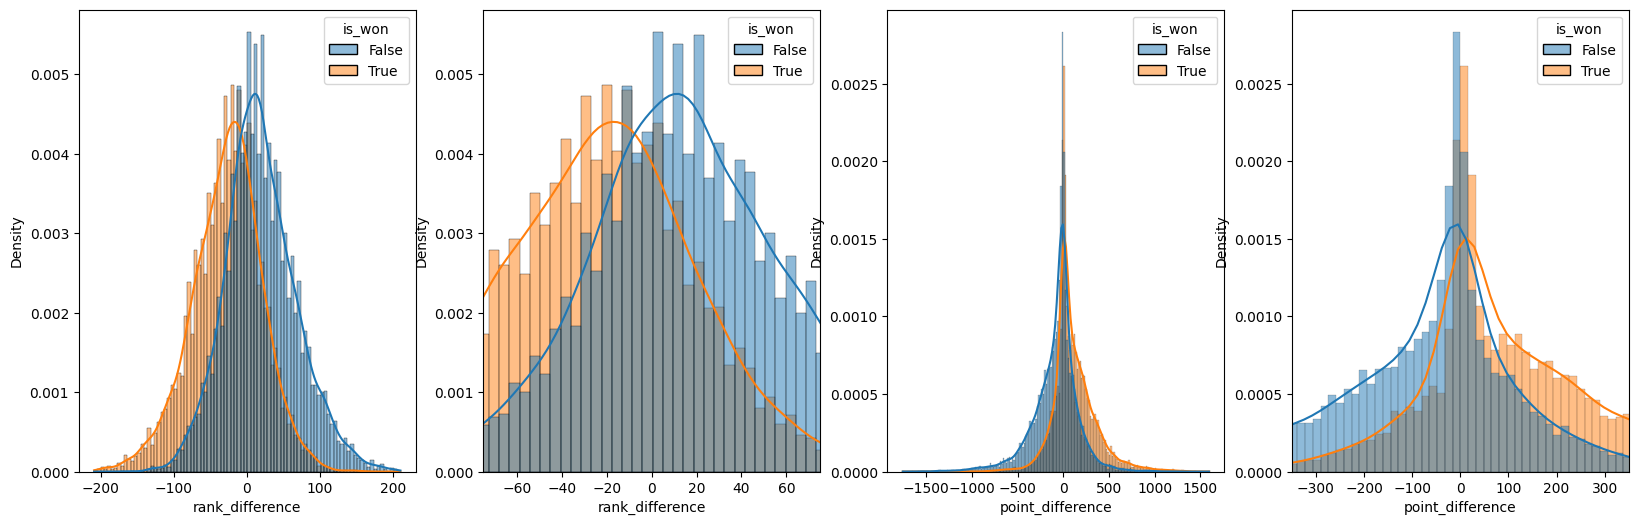

In [56]:
# Let's see how the rank and point differences are distributed
plt.figure(figsize=(20, 6))
ax = plt.subplot(141)
sns.histplot(data=matches, x='rank_difference', kde=True, hue='is_won', ax=ax, stat='density')

# Do a close-up of the rank difference near zero
ax = plt.subplot(142)
sns.histplot(data=matches, x='rank_difference', kde=True, hue='is_won', ax=ax, stat='density')
ax.set_xlim(-75, 75)

ax = plt.subplot(143)
sns.histplot(data=matches, x='point_difference', kde=True, hue='is_won', ax=ax, stat='density')

# Do a close-up of the point difference near zero
ax = plt.subplot(144)
sns.histplot(data=matches, x='point_difference', kde=True, hue='is_won', ax=ax, stat='density')
ax.set_xlim(-350, 350)

Notes:
 - The first thing we see is that the higher-ranked team wins on average.